# **Анализ данных мобильного приложения**

### Введение

Нашему вниманию предоставлены данные стартапа, занимающегося продажей продуктов питания. Необходимо исследовать поведение пользователей его мобильного приложения. Важно изучить воронку продаж. Затем проанализировать результаты A/A/B-эксперимента (пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми). В нашем распоряжении один датасет с данными.



   **Описание данных**

Датасет /datasets/logs_exp.csv:

    - EventName — название события,

    - DeviceIDHash — уникальный идентификатор пользователя,

    - EventTimestamp — время события,

    - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Каждая запись в логе — это действие пользователя, или событие.    


   **План**

1. Загрузить файл и изучить общую информацию данных.


2. Провести предобработку данных.


3. Исследовать и проверить  конкретные данные.


4. Изучить воронку событий.


5. Провести анализ результатов проводимого эксперимента.


6. Сформулировать общий вывод.

### Загрузка файла с данными и изучение общей информации

In [1]:
# импортируем библиотеки
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
import scipy.stats as st
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from plotly import graph_objects as go

import math as mth
%matplotlib inline

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t') #данные о событиях/действиях пользователя

In [3]:
#выведем строки таблицы:

print('\t\t\tИнформация о событиях/действиях пользователей')
pd.options.display.max_colwidth = 244
display (data.head())

#выведем общую информацию по таблице:

print ('\n\tИнформация о data: \n') 
data.info()

#выведем размер исходной таблицы:
print ('\nКоличество строк и столбцов:', data.shape)

			Информация о событиях/действиях пользователей


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



	Информация о data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Количество строк и столбцов: (244126, 4)


**Итак, загрузили датафрейм и рассмотрели данные. В таблице `data` 244126 строк и 4 столбца. Также видим типы данных для каждого столбца, количество не нулевых значений, предполагаемые пропуски.**

### Подготовка данных

In [4]:
# для начала приведем к нижнему регистру все наименования столбцов в датасете data и приведем их к одному виду

data.columns = data.columns.str.lower() #нижний региcтр

#переименовываем некоторые столбцы в датасете orders
data = data.rename(
           columns={'eventname' : 'event_name',
                    'deviceidhash' : 'user_id',
                    'eventtimestamp' : 'event_timestamp',
                    'expid' : 'group'
                   }
)

#выведем таблицы после изменений
print('\t\t\tИнформация о событиях/действиях пользователей')
display(data.head())

			Информация о событиях/действиях пользователей


,event_name,user_id,event_timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
#Проведем проверку на пропуски и типы данных. Откорректируем при необходимости, если нужно;

print('\t\t\tИнформация о событиях/действиях пользователей')
display(data.isna().sum())

			Информация о событиях/действиях пользователей


event_name         0
user_id            0
event_timestamp    0
group              0
dtype: int64

**Пропущенные значения отсутствуют.**

In [6]:
# проведем замену типа данных в столбце event_timestamp    
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')

#выведем общую информацию по таблице:

print ('\n\tИнформация о data: \n') 
data.info()

print('\t\t\tИнформация о событиях/действиях пользователей')
display (data.head())


	Информация о data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   group            244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB
			Информация о событиях/действиях пользователей


,event_name,user_id,event_timestamp,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [7]:
#рассмотрим временной интервал проводимого теста
print('\n\tИнформация о data')
print('Минимальная дата совершения события:', data['event_timestamp'].min())
print('Максимальная дата совершения события:', data['event_timestamp'].max())


	Информация о data
Минимальная дата совершения события: 2019-07-25 04:43:36
Максимальная дата совершения события: 2019-08-07 21:15:17


**Исходя из полученных данных, можем заметить, что начало исследуемого периода - это 25 июля 2019  04:43:36 г, а конец - 07 августа 21:15:17 2019 г.**

In [8]:
#проведем проверку на дубликаты
print ('Количество явных дубликатов data:', data.duplicated().sum())

#выведем уникальные значения

print('\t\tУникальные значения в data:')

print('\n Значения в столбце event_name')
print(data['event_name'].unique())


print('\n Значения в столбце group')
print(data['group'].unique())

Количество явных дубликатов data: 413
		Уникальные значения в data:

 Значения в столбце event_name
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']

 Значения в столбце group
[246 248 247]


In [9]:
#проверим процентное отношение дубликатов к общему количеству записей
print ('Процент дубликатов:', round((data.duplicated().sum() * 100 / len(data)),2))

Процент дубликатов: 0.17


In [10]:
# удалим дубликаты и проведем проверку еще раз, 
data = data.drop_duplicates().reset_index(drop=True)
print ('Количество явных дубликатов data:', data.duplicated().sum())

Количество явных дубликатов data: 0


In [11]:
# добавим поле с датой:
data['date'] = pd.to_datetime(data['event_timestamp'].dt.date)

print('\t\t\tИнформация о событиях/действиях пользователей')

display (data.head())
print ('\n\tИнформация о data: \n') 
data.info()

			Информация о событиях/действиях пользователей


,event_name,user_id,event_timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25



	Информация о data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   group            243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [12]:
#проверим временной интервал проводимого теста в столбцах event_timestamp и date после изменений
print('\n\tИнформация о data')
print('Минимальная дата совершения события по event_timestamp:', data['event_timestamp'].min())
print('Максимальная дата совершения события по event_timestamp:', data['event_timestamp'].max())

print('Минимальная дата совершения события по date:', data['date'].min())
print('Максимальная дата совершения события по date:', data['date'].max())


	Информация о data
Минимальная дата совершения события по event_timestamp: 2019-07-25 04:43:36
Максимальная дата совершения события по event_timestamp: 2019-08-07 21:15:17
Минимальная дата совершения события по date: 2019-07-25 00:00:00
Максимальная дата совершения события по date: 2019-08-07 00:00:00


**Как видим, данные не изменились.**

**Таким образом, была проведена предобработка данных. В частности, таблица была проверена на дубликаты и пропущенные значения (последние отсутствуют).  В ходе проверки обнаружено 413 дубликатов, после чего было подсчитано соотношение дубликатов от общего числа записей, т.к. число получилось небольшим, то дубликаты были удалены. Также в столбце event_timestamp была произведена замена типа данных. Кроме того, наименования столбцов были приведены к нижнему регистру, а также некоторые столбцы были переименованы. Добавлен отдельный столбец дат. Был рассмотрен временной интервал проводимого теста: с 25 июля по 07 августа 2019 г (минимальные и максимальные даты).**

### Изучение и проверка данных

In [13]:
#проверим сколько всего событий в логе

print ('Количество событий в логе:', data['event_name'].count())
 
display(data['event_name'].value_counts())

Количество событий в логе: 243713


MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [14]:
#проверим сколько всего пользователей в логе

print ('Количество пользователей в логе:', data['user_id'].nunique())

Количество пользователей в логе: 7551


In [15]:
#посмотрим количество уникальных пользователей для каждого события
new_table = data.groupby('event_name').agg({'user_id': 'nunique'}).reset_index()
display (new_table)

,event_name,user_id
0,CartScreenAppear,3749
1,MainScreenAppear,7439
2,OffersScreenAppear,4613
3,PaymentScreenSuccessful,3547
4,Tutorial,847


In [16]:
#проверим колько в среднем событий приходится на пользователя
new_table = data.groupby('user_id', as_index=False).agg(event_name_count = ('event_name', 'count'))
display(new_table.event_name_count.describe())

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name_count, dtype: float64

*Как видим, среднее значение 32 события, однако в данных могут быть выбросы, что влияет на корректность полученных значений. Следовательно, обратим внимание на медиану: указано 20 событий.*

In [17]:
#проверим период, за который располагаем данными. Найдем максимальную и минимальную дату (продублируем раннее указаный код)
print('\n\tИнформация о data')
print('Минимальная дата совершения события по event_timestamp:', data['event_timestamp'].min())
print('Максимальная дата совершения события по event_timestamp:', data['event_timestamp'].max())

print('Минимальная дата совершения события по date:', data['date'].min())
print('Максимальная дата совершения события по date:', data['date'].max())


	Информация о data
Минимальная дата совершения события по event_timestamp: 2019-07-25 04:43:36
Максимальная дата совершения события по event_timestamp: 2019-08-07 21:15:17
Минимальная дата совершения события по date: 2019-07-25 00:00:00
Максимальная дата совершения события по date: 2019-08-07 00:00:00


*Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можем ли быть уверенными, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?*

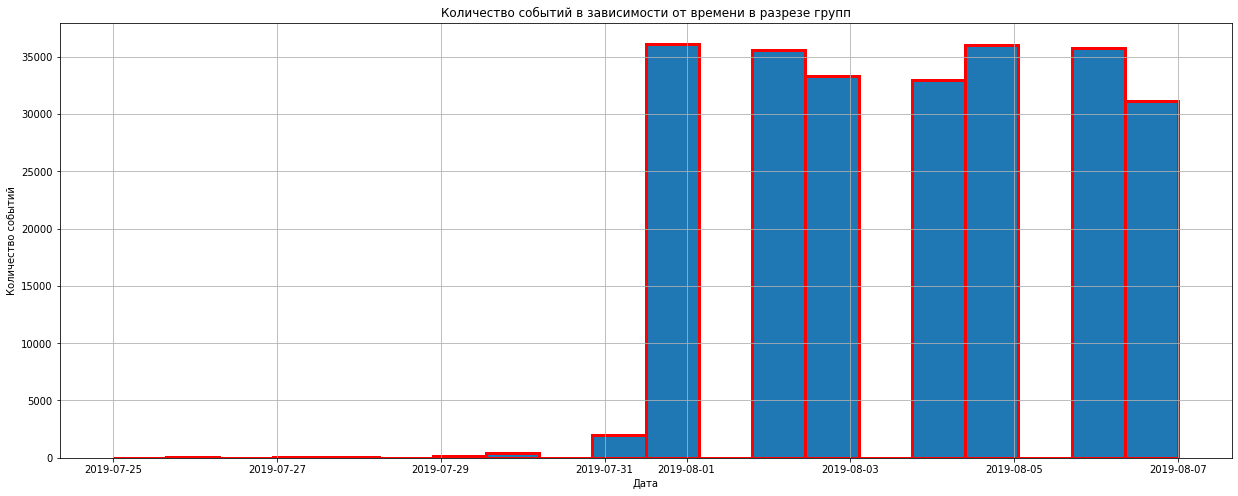

In [18]:
#Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп.

plt.figure(figsize =(21, 8))
data['date'].hist(
                bins=20, ec='red', lw= 3
                )
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

**Исходя из полученной гистограммы, видим, что данных за июль почти нет, т.е. их очень мало. Данное обстоятельство может повлиять на дальнейшее исследование.**

In [19]:
#посмотрим количество событий по каждой дате 
data_new = data['date'].value_counts().reset_index()
data_new.sort_values(by='date', ascending=False)

,index,date
0,2019-08-01,36141
1,2019-08-05,36058
2,2019-08-06,35788
3,2019-08-02,35554
4,2019-08-03,33282
5,2019-08-04,32968
6,2019-08-07,31096
7,2019-07-31,2030
8,2019-07-30,412
9,2019-07-29,184


In [20]:
#Отбросим данные за июль

new_data = data.query('date >= "2019-08-01"')
display (new_data.info())

#проверим полученный период
print('Минимальная дата совершения события по date:', new_data['date'].min())
print('Максимальная дата совершения события по date:', new_data['date'].max())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   user_id          240887 non-null  int64         
 2   event_timestamp  240887 non-null  datetime64[ns]
 3   group            240887 non-null  int64         
 4   date             240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


None

Минимальная дата совершения события по date: 2019-08-01 00:00:00
Максимальная дата совершения события по date: 2019-08-07 00:00:00


In [21]:
#проверим сколько всего событий в логе после изменений

print ('Количество событий в логе до изменений:', data['event_name'].count())
display(data['event_name'].value_counts())
print ('Количество событий в логе после изменений:', new_data['event_name'].count())
display(new_data['event_name'].value_counts())


#проверим сколько всего пользователей в логе после изменений

print ('Количество пользователей в логе до изменений:', data['user_id'].nunique())
print ('Количество пользователей в логе после изменений:', new_data['user_id'].nunique())

Количество событий в логе до изменений: 243713


MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Количество событий в логе после изменений: 240887


MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Количество пользователей в логе до изменений: 7551
Количество пользователей в логе после изменений: 7534


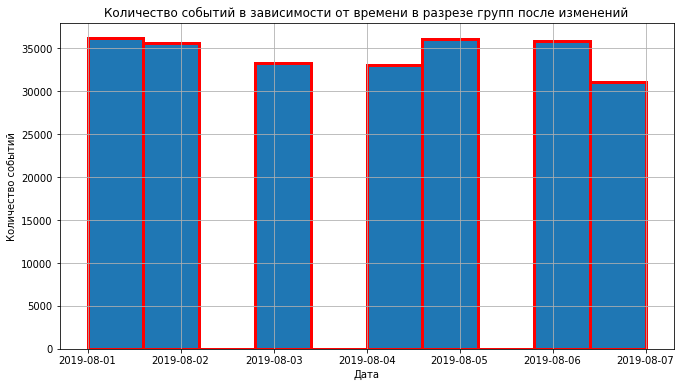

In [22]:
#построим новый график
plt.figure(figsize =(11, 6))
new_data['date'].hist(
                bins=10, ec='red', lw= 3
                )
plt.title('Количество событий в зависимости от времени в разрезе групп после изменений')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

**Как видим, больше всего событий произошло 01, 02, 05, 06 августа 2019 года. Меньше всего событий было в последний день исследования - 07 августа 2019 г.** 

In [23]:
# проверим сколько событий и пользователей мы потеряли, отбросив старые данные

ab = data['event_name'].count()
cd = new_data['event_name'].count()
diff_1 = ab - cd
print ('Количество потерянных событий:', diff_1)
print ('Потери событий составили:', '{:.2%}'.format(diff_1/ab))

ef = data['user_id'].nunique()
gh = new_data['user_id'].nunique()
diff_2 = ef - gh
print ('Количество потерянных пользователей в логе после изменений:', diff_2)
print ('Потери пользователей составили:', '{:.2%}'.format(diff_2/ef))


Количество потерянных событий: 2826
Потери событий составили: 1.16%
Количество потерянных пользователей в логе после изменений: 17
Потери пользователей составили: 0.23%


In [24]:
#Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

new_table = new_data.groupby('group').agg({'user_id': 'nunique'}).reset_index()
display (new_table)

,group,user_id
0,246,2484
1,247,2513
2,248,2537


**Как видим, количество пользователей в группе "246" - 2484 пользователя, "247" - 2513 пользователей, "248" -  2537.**

**Таким образом, мы проверили количество событий (243713) и уникальных пользователей в логе (7551), дополнительно проверили количество пользователей для каждого события. Проверили количество в среднем событий на пользователя: среднее значение 32 события, однако в данных могут быть выбросы, что влияет на корректность полученных значений. Следовательно, обратим внимание на медиану: указано 20 событий. Построили столбчатую диаграмму, которая отображает количество событий в зависимости от времени в разрезе групп. На основании полученного графика, пришли к выводу, что данных за июль очень мало, что в свою очередь может повлиять на результаты исследования в дальнейшем, поэтому удалили данные за этот период. Проверили период эксперимента после изменений: с 01 по 07 августа 2019 года. Кроме того, проверили сколько событий и пользователей мы потеряли, отбросив старые данные: 2826 событий и 17 пользователей. Также провели проверку на наличие пользователей во всех трёх экспериментальных группах : "246" - 2484 пользователя, "247" - 2513 пользователей, "248" -  2537. Дополнительно построили еще одну столбчатую диаграмму после изменений. Как видим, больше всего событий произошло 01, 02, 05, 06 августа 2019 года. Меньше всего событий было в последний день исследования - 07 августа 2019 г.** 

### Исследование воронки событий

In [25]:
#Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

new_data['event_name'].value_counts().reset_index().sort_values(by ='event_name', ascending=False)

,index,event_name
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


*Как видим, больше всего событий приходится на MainScreenAppear (появление главного экрана) - 117328 событий, меньше всего на Tutorial (руководство/инструкция) - 1005 событий. На OffersScreenAppear (появление предложение на экране) - 46333 события, CartScreenAppear (появление корзины на экране (скорей всего с товаром) - 42303 события, PaymentScreenSuccessful (платеж прошел успешно) - 33918 событий.*

In [26]:
#Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.  Также посчитаем долю пользователей, которые хоть раз совершали событие.

count_user = new_data['user_id'].nunique()
table_1 = new_data.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
table_1.columns = ['count_events', 'count_users']
table_1 = table_1.reset_index()
table_1['ratio_user'] = (table_1['count_users'] / count_user).map('{:.2%}'.format)
display(table_1)

,event_name,count_events,count_users,ratio_user
0,MainScreenAppear,117328,7419,98.47%
1,OffersScreenAppear,46333,4593,60.96%
2,CartScreenAppear,42303,3734,49.56%
3,PaymentScreenSuccessful,33918,3539,46.97%
4,Tutorial,1005,840,11.15%


*Заметим, что на событие MainScreenAppear (появление главного экрана) приходится 98.47% пользователей из всех, что вполне объяснимо. На Tutorial (руководство/инструкция) приходится всего лишь 11.15%. Возможно это связано с легкостью в использовании приложения (следовательно, пользователи не переходят к руководству пользования, не пользуются инструкциями) либо техническими сбоями/багами при открытии инструкции/переходе к странице с руководством.*

In [27]:
#Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку  (их не нужно учитывать при расчёте воронки).

Полагаем, что для большинства пользователей последовательность событий выглядит следующим образом:

1. MainScreenAppear - главный экран.

2. OffersScreenAppear - экран с предложениями (товарами).

3. CartScreenAppear - экран с корзиной (товаров).

4. PaymentScreenSuccessful - экран с подтверждением оплаты.

Как уже отметили ранее, к шагу Tutorial прибегает сравнительно небольшой процент пользователей. Возможно это связано с легкостью в использовании приложения (следовательно, пользователи не переходят к руководству пользования, не пользуются инструкциями) либо техническими сбоями/багами при открытии инструкции/переходе к странице с руководством. Считаем вполне логичным убрать данный шаг из последовательности событий.

In [27]:
#По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

#строим сводную таблицу
table_3 = new_data.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='date',
    aggfunc='min')

print('Всего пользователей: 100 %')
print('Перешли к экрану с предложениями (товарами):', 
     '{:.2%}'.format(table_3['OffersScreenAppear'].count() / table_3['MainScreenAppear'].count()))
print('Перешли к корзине:', 
      '{:.2%}'.format(table_3['CartScreenAppear'].count() / table_3['OffersScreenAppear'].count()))
print('Оплатили товары (переход к экрану с подтверждением оплаты):',
      '{:.2%}'.format(table_3['PaymentScreenSuccessful'].count() / table_3['CartScreenAppear'].count()))

Всего пользователей: 100 %
Перешли к экрану с предложениями (товарами): 61.91%
Перешли к корзине: 81.30%
Оплатили товары (переход к экрану с подтверждением оплаты): 94.78%


In [29]:
#дополнительно посмотрим сколько пользоватлей после главного экрана все-таки перешли к иснтрукции
print('Перешли к экрану с руководством:', 
     '{:.2%}'.format(table_3['Tutorial'].count() / table_3['MainScreenAppear'].count()))

Перешли к экрану с руководством: 11.32%


*Таким образом, видим, что не все пользователи, заходящие в приложение доходят до последнего шага. Всего лишь 61.91% переходят к экрану с предложениями (товарами). Большая часть пользователей после просмотра товаром все-таки добавляет их в корзину и переходит к просмотру - 81.30%. Почти все пользователи после просмотра корзины переходят к оплате товаров - 94.78%.*

In [29]:
# Выясним на каком шаге теряем больше всего пользователей

# Посчитаем количество уникальных пользователей для каждого события
table_new = new_data.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
display (table_new)

# построим диаграмму воронки
table_new = table_new[table_new['event_name'] != 'Tutorial']
fig = go.Figure(go.Funnel(
     y = table_new ['event_name'],
     x = table_new ['user_id']))
fig.update_layout(title_text='Диаграмма воронки пользователей для каждого события', title_x=0.5)
fig.show()

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


*Как видим, больше всего пользователей теряется при переходе к OffersScreenAppear (экрану с предложениями (товарами) от MainScreenAppear (главного экрана).*

In [30]:
# Выясним какая доля пользователей доходит от первого события до оплаты

#рассчитаем процентное изменение на каждом этапе
new_type = table_new.sort_values('user_id', ascending=False)['user_id'].pct_change()
display (new_type)

1         NaN
2   -0.380914
0   -0.187024
3   -0.052223
Name: user_id, dtype: float64

Получаем:
    
    -OffersScreenAppear - 38% ;
    
    -CartScreenAppear  - 19% ;
    
    -PaymentScreenSuccessful - 5%.
Следовательно, теряется 62% пользователей. Таким образом, от первого события до оплаты доходит 38%.

**Таким образом, получаем 5 видов событий. Как видим, больше всего событий приходится на MainScreenAppear (появление главного экрана) - 117328 событий, меньше всего на Tutorial (руководство/инструкция) - 1005 событий. На OffersScreenAppear (появление предложение на экране) - 46333 события, CartScreenAppear (появление корзины на экране (скорей всего с товаром) - 42303 события, PaymentScreenSuccessful (платеж прошел успешно) - 33918 событий.**

**Отметим, что на событие MainScreenAppear (появление главного экрана) приходится 98.47% пользователей из всех, что вполне объяснимо. На Tutorial (руководство/инструкция) приходится всего лишь 11.15%. Возможно это связано с легкостью в использовании приложения (следовательно, пользователи не переходят к руководству пользования, не пользуются инструкциями) либо техническими сбоями/багами при открытии инструкции/переходе к странице с руководством.**

**Полагаем, что для большинства пользователей последовательность событий выглядит следующим образом:**

1. MainScreenAppear - главный экран.

2. OffersScreenAppear - экран с предложениями (товарами).

3. CartScreenAppear - экран с корзиной (товаров).

4. PaymentScreenSuccessful - экран с подтверждением оплаты.

**Как уже отметили ранее, к шагу Tutorial прибегает сравнительно небольшой процент пользователей. Возможно это связано с легкостью в использовании приложения (следовательно, пользователи не переходят к руководству пользования, не пользуются инструкциями) либо техническими сбоями/багами при открытии инструкции/переходе к странице с руководством. Считаем вполне логичным убрать данный шаг из последовательности событий.**

**Кроме того, видим, что не все пользователи, заходящие в приложение доходят до последнего шага. Всего лишь 61.91% переходят к экрану с предложениями (товарами). Большая часть пользователей после просмотра товаром все-таки добавляет их в корзину и переходит к просмотру - 81.30%. Почти все пользователи после просмотра корзины переходят к оплате товаров - 94.78%.**

**Отметим, больше всего пользователей теряется при переходе к OffersScreenAppear (экрану с предложениями (товарами) от MainScreenAppear (главного экрана).**

**Выяснисли, что теряется 62% пользователей. Таким образом, от первого события до оплаты доходит 38%.**

### Изучение результатов эксперимента

In [31]:
# Рассчитаем пользователей в каждой экспериментальной группе 

#продублируем ранее проведенный расчет
new_table = new_data.groupby('group').agg({'user_id': 'nunique'}).reset_index()
display (new_table)

,group,user_id
0,246,2484
1,247,2513
2,248,2537


**Таким образом, на группу "246" приходится 2484 пользователя, "247" - 2513 пользователей, "248" - 2537 пользователей.**


*Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.*

In [32]:
# Рассчитаем разницу между 246 и 247 группам
group_246 = new_data.query('group == 246').groupby('group')['user_id'].nunique().reset_index()
group_247 = new_data.query('group == 247').groupby('group')['user_id'].nunique().reset_index()
difference = 1 - group_246.iloc[0]['user_id'] / group_247.iloc[0]['user_id']
print('Разница между  группам 246 и 247: {:.1%}'.format(difference))

Разница между  группам 246 и 247: 1.2%


**Разница между выборками 246 и 247 составляет 1.2%. Это довольно незначительный коэффициент.**

In [33]:
# отбираем группы  
group_a = new_data.query('group == "246"') 
group_b = new_data.query('group == "247"') 
group_c = new_data.query('group == "248"') 
  
# получаем id пользователей, попавших в обе группы 
group_double=list(np.intersect1d(group_a['user_id'], group_b['user_id']))
print ('Количество пользователей, попавших в обе группы (246 и 247):', len(group_double))
group_double_2=list(np.intersect1d(group_a['user_id'], group_c['user_id']))
print ('Количество пользователей, попавших в обе группы (246 и 248):', len(group_double_2))

group_double_3=list(np.intersect1d(group_b['user_id'], group_c['user_id']))
print ('Количество пользователей, попавших в обе группы (247 и 248):', len(group_double_3))

Количество пользователей, попавших в обе группы (246 и 247): 0
Количество пользователей, попавших в обе группы (246 и 248): 0
Количество пользователей, попавших в обе группы (247 и 248): 0


*Как видим, пользователей одновременно попавших в 2 группы нет.*

In [34]:
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
new_data.groupby('user_id').agg({'group':'nunique'}).query('group > 1') 

,group
user_id,


*Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?*

*Сформулируем гипотезы:*

H0: нет оснований считать доли разными

H1: между долями есть значимая разница

In [35]:
# Создадим функцию, считающую статистическую значимость между группами. Датафрейм будем обрабатывать внутри функции, группы будем передавать в виде списка
def abcd (new_data, group_new, alpha):
    #найдем уникальных пользователей в каждой группе
    users = [new_data.query('group == @group_id')['user_id'].nunique() for group_id in group_new]
    #перебираем все экспериментальные группы для каждого события, считаем количество пользователей и долю
    for event in new_data.event_name.unique():
        events = [new_data.query('group == %d and event_name == "%s"' % (group_id, event))['user_id'].nunique() for group_id in group_new]
        # сравниваем кол-во уникальных юзеров на каждом шаге группы к кол-ву уникальных юзеров в этой группе всего
        p1 = events[0] / users[0] #считаем долю для 1 группы
        p2 = events[1] / users[1] #считаем долю для 2 группы
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 # разница в датасетах
        
        z_value = difference / mth.sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) #считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
        )
        
        distr = st.norm(0, 1) #распределение
        p_value = (1 - distr.cdf(abs(z_value))) * 2 #считаем p-value
        
        print(event)
        print(p1, p2)
        print('p-значение: ', p_value)
        #сравниваем p-value и alpha
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
        print('_____________________________________________')
        print(' ')

In [36]:
#посмотрим на события в 246 и 247 группах
abcd(new_data, [246, 247], 0.05)

Tutorial
0.11191626409017713 0.11261440509351373
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
_____________________________________________
 
MainScreenAppear
0.9863123993558777 0.9852765618782332
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
_____________________________________________
 
OffersScreenAppear
0.6207729468599034 0.6048547552725826
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
_____________________________________________
 
CartScreenAppear
0.5096618357487923 0.4926382809391166
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
_____________________________________________
 
PaymentScreenSuccessful
0.4830917874396135 0.

In [37]:
#посмотрим на события в 246 и 247 группах при alpha 0.01
abcd(new_data, [246, 247], 0.01)

Tutorial
0.11191626409017713 0.11261440509351373
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
_____________________________________________
 
MainScreenAppear
0.9863123993558777 0.9852765618782332
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
_____________________________________________
 
OffersScreenAppear
0.6207729468599034 0.6048547552725826
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
_____________________________________________
 
CartScreenAppear
0.5096618357487923 0.4926382809391166
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
_____________________________________________
 
PaymentScreenSuccessful
0.4830917874396135 0.

*Как видим, между группами 246 и 247 нет статистически значимых различий.*

In [38]:
#посмотрим на события в 246 и 248 группах
abcd(new_data, [246, 248], 0.05)

Tutorial
0.11191626409017713 0.10997240835632636
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
_____________________________________________
 
MainScreenAppear
0.9863123993558777 0.9826566811194324
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
_____________________________________________
 
OffersScreenAppear
0.6207729468599034 0.6034686637761135
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
_____________________________________________
 
CartScreenAppear
0.5096618357487923 0.48482459597950334
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
_____________________________________________
 
PaymentScreenSuccessful
0.4830917874396135 

In [39]:
#посмотрим на события в 246 и 248 группах
abcd(new_data, [246, 248], 0.01)

Tutorial
0.11191626409017713 0.10997240835632636
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
_____________________________________________
 
MainScreenAppear
0.9863123993558777 0.9826566811194324
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
_____________________________________________
 
OffersScreenAppear
0.6207729468599034 0.6034686637761135
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
_____________________________________________
 
CartScreenAppear
0.5096618357487923 0.48482459597950334
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
_____________________________________________
 
PaymentScreenSuccessful
0.4830917874396135 

*Как видим, между группами 246 и 248 нет статистически значимых различий.*

In [40]:
#посмотрим на события в 247 и 248 группах
abcd(new_data, [247, 248], 0.05)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
_____________________________________________
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
_____________________________________________
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
_____________________________________________
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
_____________________________________________
 
PaymentScreenSuccessful
0.46080382013529647 0.

In [41]:
#посмотрим на события в 247 и 248 группах
abcd(new_data, [247, 248], 0.01)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
_____________________________________________
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
_____________________________________________
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
_____________________________________________
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
_____________________________________________
 
PaymentScreenSuccessful
0.46080382013529647 0.

*Как видим, между группами 246 и 248 нет статистически значимых различий.*

In [42]:
# объединим две контрольные группы в одну и оставим ее под номером 247.
sum_dats = new_data.copy()
sum_dats["user_id"].replace({246:247}, inplace=True)

In [43]:
abcd(sum_dats, [247, 248], 0.01)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
_____________________________________________
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
_____________________________________________
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
_____________________________________________
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
_____________________________________________
 
PaymentScreenSuccessful
0.46080382013529647 0.

In [44]:
abcd(sum_dats, [247, 248], 0.05)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
_____________________________________________
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
_____________________________________________
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
_____________________________________________
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
_____________________________________________
 
PaymentScreenSuccessful
0.46080382013529647 0.

*Как видим, между группами объединенными группам 246+247 и 248 нет статистически значимых различий.*

*Были проведены проверки при разных уровнях .01 и .05. Всего было сделано 20 проверок статистических гипотез  при каждом урвоне.*

**Таким образом, на группу "246" приходится 2484 пользователя, "247" - 2513 пользователей, "248" - 2537 пользователей. **Разница между выборками 246 и 247 составляет 1.2%. Это довольно незначительный коэффициент. Были проведены проверки при разных уровнях значимости  .01 и .05. Всего было сделано 20 проверок статистических гипотез  при каждом урвоне. В ходе проверки не было выявлено значимой разницы между группами.  Следовательно, считаем, что на поведение пользователей изменение шрифта не оказало значимого эффекта.**

### Общий вывод
_В ходе проведенной работы было выполнено следующее:_

**1. Загрузили датафрейм /datasets/logs_exp.csv - data. Рассмотрели данные указанного датафрейма.**

**2. Провели поиск пропущенных значений, в ходе которого пришли к выводу, что пропущенные значения отсутствуют.**

**3. Обнаружено 413 дубликатов, после чего было подсчитано соотношение дубликатов от общего числа записей, т.к. число получилось небольшим, то дубликаты были удалены.**

**4. Произвели замену наименований столбцов, в частности привели к нижнему регистру все наименования столбцов в датасете data, 
а также переименовали некоторые столбцы**.

**5. Заменили следующий типы данных:**

* с object на datetime64[ns] в столбце event_timestamp   - необходимо для удобства дальнейшей работы с указанными данными.

**6. Был рассмотрен временной интервал проводимого теста: с 25 июля по 07 августа 2019 г (минимальные и максимальные даты).**

**7. Проведены подсчеты общего количества событий (243713) и уникальных пользователей (7551) в логе, дополнительно проверили количество пользователей для каждого события. Проверили количество в среднем событий на пользователя: среднее значение 32 события, однако в данных могут быть выбросы, что влияет на корректность полученных значений. Следовательно, обратим внимание на медиану: указано 20 событий. Построили столбчатую диаграмму, которая отображает количество событий в зависимости от времени в разрезе групп. На основании полученного графика, пришли к выводу, что данных за июль очень мало, что в свою очередь может повлиять на результаты исследования в дальнейшем, поэтому удалили данные за этот период. Проверили период эксперимента после изменений: с 01 по 07 августа 2019 года. Кроме того, проверили сколько событий и пользователей мы потеряли, отбросив старые данные: 2826 событий и 17 пользователей. Также провели проверку на наличие пользователей во всех трёх экспериментальных группах : "246" - 2484 пользователя, "247" - 2513 пользователей, "248" -  2537. Дополнительно построили еще одну столбчатую диаграмму после изменений. Как видим, больше всего событий произошло 01, 02, 05, 06 августа 2019 года. Меньше всего событий было в последний день исследования - 07 августа 2019 г.** 

**8. Таким образом, получаем 5 видов событий. Как видим, больше всего событий приходится на MainScreenAppear (появление главного экрана) - 117328 событий, меньше всего на Tutorial (руководство/инструкция) - 1005 событий. На OffersScreenAppear (появление предложение на экране) - 46333 события, CartScreenAppear (появление корзины на экране (скорей всего с товаром) - 42303 события, PaymentScreenSuccessful (платеж прошел успешно) - 33918 событий.**

**Отметим, что на событие MainScreenAppear (появление главного экрана) приходится 98.47% пользователей из всех, что вполне объяснимо. На Tutorial (руководство/инструкция) приходится всего лишь 11.15%. Возможно это связано с легкостью в использовании приложения (следовательно, пользователи не переходят к руководству пользования, не пользуются инструкциями) либо техническими сбоями/багами при открытии инструкции/переходе к странице с руководством.**

**Полагаем, что для большинства пользователей последовательность событий выглядит следующим образом:**

1. MainScreenAppear - главный экран.

2. OffersScreenAppear - экран с предложениями (товарами).

3. CartScreenAppear - экран с корзиной (товаров).

4. PaymentScreenSuccessful - экран с подтверждением оплаты.

**Как уже отметили ранее, к шагу Tutorial прибегает сравнительно небольшой процент пользователей. Возможно это связано с легкостью в использовании приложения (следовательно, пользователи не переходят к руководству пользования, не пользуются инструкциями) либо техническими сбоями/багами при открытии инструкции/переходе к странице с руководством. Считаем вполне логичным убрать данный шаг из последовательности событий.**

**Кроме того, видим, что не все пользователи, заходящие в приложение доходят до последнего шага. Всего лишь 61.91% переходят к экрану с предложениями (товарами). Большая часть пользователей после просмотра товаром все-таки добавляет их в корзину и переходит к просмотру - 81.30%. Почти все пользователи после просмотра корзины переходят к оплате товаров - 94.78%.**

**Отметим, больше всего пользователей теряется при переходе к OffersScreenAppear (экрану с предложениями (товарами) от MainScreenAppear (главного экрана).**

**Выяснили, что теряется 62% пользователей. Таким образом, от первого события до оплаты доходит 38%.**

**9. Таким образом, на группу "246" приходится 2484 пользователя, "247" - 2513 пользователей, "248" - 2537 пользователей. Разница между выборками 246 и 247 составляет 1.2%. Это довольно незначительный коэффициент. Кроме того, рассмотрели возможность присутствия однгого пользователя в разных группах. Пришли к выводу, что пользователей одновременно попавших в 2 группы нет. Были проведены проверки при разных уровнях значимости  .01 и .05. Всего было сделано 20 проверок статистических гипотез  при каждом урвоне. В ходе проверки не было выявлено значимой разницы между группами.  Следовательно, считаем, что на поведение пользователей изменение шрифта не оказало значимого эффекта.**